# Global imports

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
from collections import Counter

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from qksvm.QKSVC import QKSVC

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

seed = 12345

# Blobs dataset

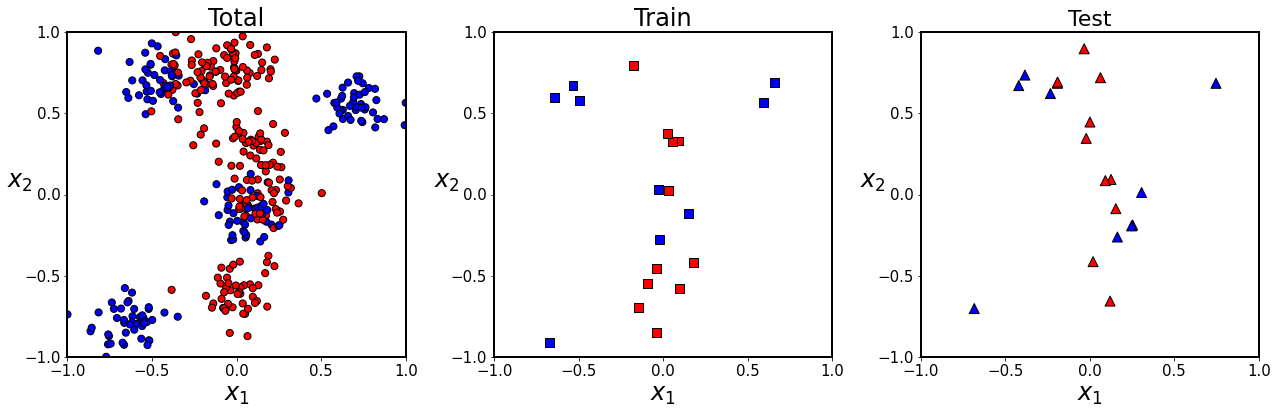

In [350]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

n_samples = 400
X, y = make_blobs(n_samples=n_samples, n_features=2, centers=9, random_state=120, shuffle=True, cluster_std=1.2)
y[y%2 == 0] = -1
y[y > 0] = 1

xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax)).fit_transform(X)
axes = [xmin, xmax, xmin, xmax]

train_size = 20
test_size = 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=101
)

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# RBF SVM

Best grid search parameters: {'C': 100, 'gamma': 1.6}
Best training score: 0.898989898989899

Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.99
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.81
                  F1:  0.80
             ROC_AUC:  0.94
                 MCC:  0.62


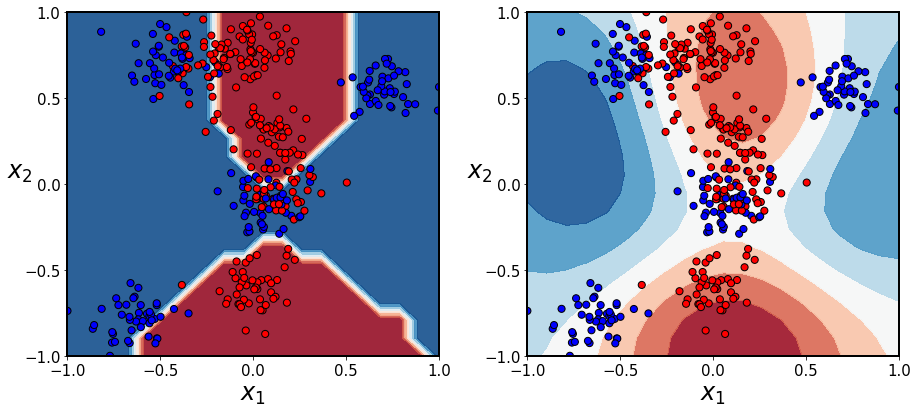

In [293]:
param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

train_size = 40
test_size = 20
_X_train, _X_test, _y_train, _y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=101,
)

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
clf.fit(_X_train, _y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

train_scores = get_scores(clf.best_estimator_, _X_train, _y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(clf.best_estimator_, _X_test,  _y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(clf.best_estimator_, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(clf.best_estimator_, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

## Model cross-validation

In [296]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

train_size = 20
test_size = 20
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        clf = SVC(kernel='rbf', C=100, gamma=1.6)
        clf.fit(X[train], y[train])

        train_scores = get_scores(clf, X[train,:], y[train])
        test_scores = get_scores(clf, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)

print('')
print('==== Cross-Validation Scores ====')
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Train set:
   Balanced accuracy:  0.94 +- 0.06
                  F1:  0.94 +- 0.06
             ROC_AUC:  0.98 +- 0.03
                 MCC:  0.89 +- 0.11

Test set:
   Balanced accuracy:  0.79 +- 0.09
                  F1:  0.79 +- 0.09
             ROC_AUC:  0.85 +- 0.10
                 MCC:  0.59 +- 0.18


In [297]:
np.random.seed(seed)

scores_tr = []
scores_tt = []

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 50, 100],
}

train_size = 40
test_size = 20
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        clf = GridSearchCV(
            estimator=SVC(kernel='rbf'),
            param_grid=param_grid,
            scoring='balanced_accuracy',
            n_jobs=1,
            refit=True,
            cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=_seed),
        )

        clf.fit(X[train,:], y[train])

        train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
        test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)

print('')
print('==== Cross-Validation Scores ====')
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Train set:
   Balanced accuracy:  0.90 +- 0.06
                  F1:  0.90 +- 0.06
             ROC_AUC:  0.95 +- 0.08
                 MCC:  0.81 +- 0.10

Test set:
   Balanced accuracy:  0.79 +- 0.09
                  F1:  0.79 +- 0.09
             ROC_AUC:  0.86 +- 0.09
                 MCC:  0.60 +- 0.17


In [298]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0

test_size = 20
n_splits = 5

for train_size in [10, 20, 40, 60, 80, 100]:

    scores_tr = []
    scores_te = []
    for _seed in np.random.randint(2**16-1, size=5):
        # print('rnd seed', _seed)

        cv = StratifiedShuffleSplit(
            n_splits=n_splits, 
            train_size=train_size, test_size=test_size, 
            random_state=_seed
        )

        i = 0
        for train, test in cv.split(X, y):
            i += 1
            # print(f"Train/Test CV Subset {i}")

            clf = SVC(kernel='rbf', C=100.0, gamma=1.6)
            clf.fit(X[train], y[train])

            train_scores = get_scores(clf, X[train,:], y[train])
            test_scores = get_scores(clf, X[test,:], y[test])
            scores_tr.append(train_scores)
            scores_te.append(test_scores)

    scores_tr = np.array(scores_tr)
    scores_te = np.array(scores_te)
    print(f"{train_size:>.1f}  \
{np.mean(scores_tr[:,0]):>.2f} {np.std(scores_tr[:,0]):>.2f}  \
{np.mean(scores_tr[:,3]):>.2f} {np.std(scores_tr[:,3]):>.2f}  \
{np.mean(scores_te[:,0]):>.2f} {np.std(scores_te[:,0]):>.2f}  \
{np.mean(scores_te[:,3]):>.2f} {np.std(scores_te[:,3]):>.2f}")
        

10.0  0.98 0.04  0.98 0.06  0.68 0.12  0.38 0.26
20.0  0.94 0.06  0.89 0.11  0.72 0.10  0.46 0.21
40.0  0.93 0.04  0.86 0.07  0.79 0.09  0.61 0.18
60.0  0.90 0.05  0.80 0.10  0.81 0.09  0.64 0.18
80.0  0.90 0.03  0.81 0.06  0.82 0.10  0.67 0.20
100.0  0.90 0.03  0.80 0.06  0.81 0.09  0.64 0.16


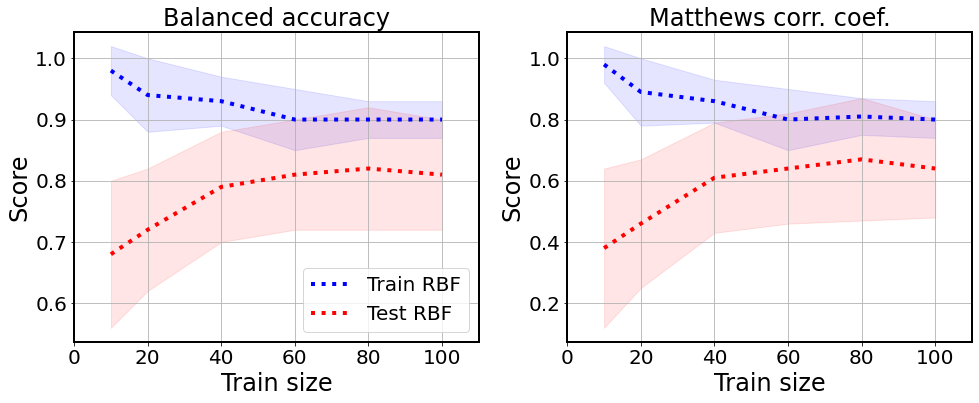

In [299]:
import pandas as pd
from io import StringIO

TESTDATA = StringIO("""
size acc_tr_mean acc_tr_std  mcc_tr_mean mcc_tr_std  acc_te_mean acc_te_std  mcc_te_mean mcc_te_std
10.0  0.98 0.04  0.98 0.06  0.68 0.12  0.38 0.26
20.0  0.94 0.06  0.89 0.11  0.72 0.10  0.46 0.21
40.0  0.93 0.04  0.86 0.07  0.79 0.09  0.61 0.18
60.0  0.90 0.05  0.80 0.10  0.81 0.09  0.64 0.18
80.0  0.90 0.03  0.81 0.06  0.82 0.10  0.67 0.20
100.0  0.90 0.03  0.80 0.06  0.81 0.09  0.64 0.16
""")

df_rbf = pd.read_table(TESTDATA, sep="\s+")

# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, figsize=(14,6))

df_rbf.plot(ax=ax[0], x='size', y='acc_tr_mean', yerr=None, c='blue', lw=4, ls=':', marker=None, markersize=10, label='Train RBF', legend=False)
ax[0].fill_between(df_rbf['size'], df_rbf['acc_tr_mean']-df_rbf['acc_tr_std'], df_rbf['acc_tr_mean']+df_rbf['acc_tr_std'], alpha=0.1, color='blue')
df_rbf.plot(ax=ax[0], x='size', y='acc_te_mean', yerr=None, c='red', lw=4, ls=':', marker=None, markersize=10, label='Test RBF', legend=False)
ax[0].fill_between(df_rbf['size'], df_rbf['acc_te_mean']-df_rbf['acc_te_std'], df_rbf['acc_te_mean']+df_rbf['acc_te_std'], alpha=0.1, color='red')

df_rbf.plot(ax=ax[1], x='size', y='mcc_tr_mean', yerr=None, c='blue', lw=4, ls=':', marker=None, markersize=10, label='Train RBF', legend=False)
ax[1].fill_between(df_rbf['size'], df_rbf['mcc_tr_mean']-df_rbf['mcc_tr_std'], df_rbf['mcc_tr_mean']+df_rbf['mcc_tr_std'], alpha=0.1, color='blue')
df_rbf.plot(ax=ax[1], x='size', y='mcc_te_mean', yerr=None, c='red', lw=4, ls=':', marker=None, markersize=10, label='Test RBF', legend=False)
ax[1].fill_between(df_rbf['size'], df_rbf['mcc_te_mean']-df_rbf['mcc_te_std'], df_rbf['mcc_te_mean']+df_rbf['mcc_te_std'], alpha=0.1, color='red')


ax[0].set_title('Balanced accuracy')
ax[1].set_title('Matthews corr. coef.')
for i in range(len(ax)):
    ax[i].set_xlabel('Train size', fontsize=24)
    ax[i].set_ylabel('Score', fontsize=24)
    ax[i].set_xlim(0, 110)
    ax[i].grid()
ax[0].legend(loc='lower right')
plt.tight_layout()
plt.show()

# QKSVC

In [306]:
def model(params, seed=None, plot=False):

    qsvc = QKSVC(
        n_qubits=params['n_qubits'],
        n_layers=params['n_layers'],
        feature_map=params['feature_map'], entanglement='linear',
        alpha=params['alpha'], C=params['C'], 
        random_state=seed
    )
    
    if plot:
        qsvc.fit(X_train, y_train)
        
        train_scores = get_scores(qsvc, X_train, y_train)
        print_scores(train_scores, title='Train scores:')

        test_scores  = get_scores(qsvc, X_test,  y_test)
        print_scores(test_scores, title='Test scores:')
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
        plot_predictions(qsvc, ax1, axes, N=20)
        plot_dataset(X, y, ax1, axes)
        plot_decisions(qsvc, ax2, axes, N=20)
        plot_dataset(X, y, ax2, axes)
        plt.tight_layout()
        plt.show()
        
    return qsvc

## RX


Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.98
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.81
                  F1:  0.80
             ROC_AUC:  0.90
                 MCC:  0.62


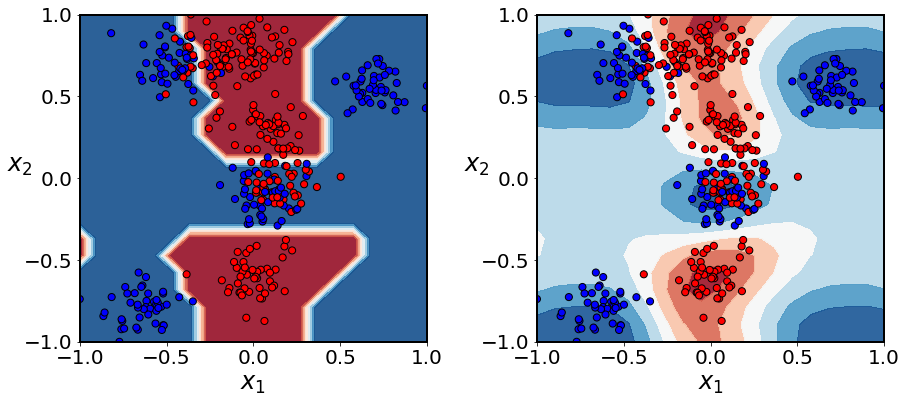

QKSVC(alpha=4.0,
      backend=<qiskit.utils.quantum_instance.QuantumInstance object at 0x7fa31dc4b5b0>,
      feature_map=['rx'], n_qubits=6, random_state=12345)

In [319]:
params = {'n_qubits': 6, 'n_layers': 1, 'feature_map': ['rx'], 'alpha': 4.0, 'C': 1.0}
model(params, seed=seed, plot=True)

In [320]:
np.random.seed(seed)

train_size = 20
test_size = 20
n_splits = 5

scores_tr = []
scores_te = []

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        params = {'n_qubits': 6, 'n_layers': 1, 'feature_map': ['rx'], 'alpha': 4.0, 'C': 1.0} 
        qsvc = QKSVC(
            n_qubits=params['n_qubits'],
            n_layers=params['n_layers'],
            feature_map=params['feature_map'], entanglement='linear',
            alpha=params['alpha'], C=params['C'], 
            random_state=_seed
        )
        qsvc.fit(X[train], y[train])

        train_scores = get_scores(qsvc, X[train], y[train])
        test_scores = get_scores(qsvc, X[test], y[test])
        scores_tr.append(train_scores)
        scores_te.append(test_scores)
        
        train_scores = get_scores(qsvc, X[train], y[train])
        test_scores = get_scores(qsvc, X[test], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.9444444444444444

Train set:
   Balanced accuracy:  0.93 +- 0.05
                  F1:  0.93 +- 0.05
             ROC_AUC:  0.98 +- 0.03
                 MCC:  0.87 +- 0.10

Test set:
   Balanced accuracy:  0.82 +- 0.07
                  F1:  0.82 +- 0.07
             ROC_AUC:  0.90 +- 0.07
                 MCC:  0.67 +- 0.14


In [322]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0

test_size = 20
n_splits = 5

for train_size in [10, 20, 40, 60, 80, 100]:

    scores_tr = []
    scores_te = []
    for _seed in np.random.randint(2**16-1, size=5):
        # print('rnd seed', _seed)

        cv = StratifiedShuffleSplit(
            n_splits=n_splits, 
            train_size=train_size, test_size=test_size, 
            random_state=_seed
        )

        i = 0
        for train, test in cv.split(X, y):
            i += 1
            # print(f"Train/Test CV Subset {i}")
            
            params = {'n_qubits': 6, 'n_layers': 1, 'feature_map': ['rx', ], 'alpha': 4.0, 'C': 1.0} 
            qsvc = QKSVC(
                n_qubits=params['n_qubits'],
                n_layers=params['n_layers'],
                feature_map=params['feature_map'], entanglement='linear',
                alpha=params['alpha'], C=params['C'], 
                random_state=_seed
            )
            qsvc.fit(X[train], y[train])

            train_scores = get_scores(qsvc, X[train], y[train])
            test_scores = get_scores(qsvc, X[test], y[test])
            scores_tr.append(train_scores)
            scores_te.append(test_scores)

    scores_tr = np.array(scores_tr)
    scores_te = np.array(scores_te)
    print(f"{train_size:>.1f}  \
{np.mean(scores_tr[:,0]):>.2f} {np.std(scores_tr[:,0]):>.2f}  \
{np.mean(scores_tr[:,3]):>.2f} {np.std(scores_tr[:,3]):>.2f}  \
{np.mean(scores_te[:,0]):>.2f} {np.std(scores_te[:,0]):>.2f}  \
{np.mean(scores_te[:,3]):>.2f} {np.std(scores_te[:,3]):>.2f}")
        

10.0  0.96 0.06  0.94 0.11  0.77 0.10  0.58 0.18
20.0  0.93 0.05  0.87 0.09  0.82 0.09  0.67 0.17
40.0  0.91 0.04  0.83 0.07  0.84 0.08  0.71 0.15
60.0  0.89 0.04  0.79 0.09  0.87 0.07  0.76 0.13
80.0  0.90 0.03  0.80 0.06  0.85 0.08  0.71 0.16
100.0  0.89 0.03  0.79 0.06  0.85 0.07  0.72 0.14


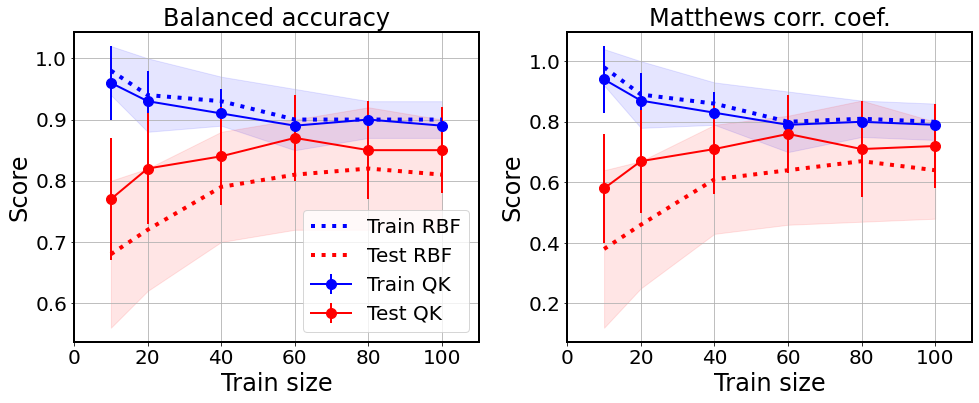

In [331]:
import pandas as pd
from io import StringIO

TESTDATA = StringIO("""
size acc_tr_mean acc_tr_std  mcc_tr_mean mcc_tr_std  acc_te_mean acc_te_std  mcc_te_mean mcc_te_std
10.0  0.96 0.06  0.94 0.11  0.77 0.10  0.58 0.18
20.0  0.93 0.05  0.87 0.09  0.82 0.09  0.67 0.17
40.0  0.91 0.04  0.83 0.07  0.84 0.08  0.71 0.15
60.0  0.89 0.04  0.79 0.09  0.87 0.07  0.76 0.13
80.0  0.90 0.03  0.80 0.06  0.85 0.08  0.71 0.16
100.0  0.89 0.03  0.79 0.06  0.85 0.07  0.72 0.14
""")

df = pd.read_table(TESTDATA, sep="\s+")

# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# acc
df.plot(ax=ax[0], x='size', y='acc_tr_mean', yerr='acc_tr_std', c='blue', lw=2, ls='-', marker='o', markersize=10, label='Train QK')
df.plot(ax=ax[0], x='size', y='acc_te_mean', yerr='acc_te_std', c='red', lw=2, ls='-', marker='o', markersize=10, label='Test QK')

df_rbf.plot(ax=ax[0], x='size', y='acc_tr_mean', yerr=None, c='blue', lw=4, ls=':', marker=None, markersize=10, label='Train RBF', legend=False)
ax[0].fill_between(df_rbf['size'], df_rbf['acc_tr_mean']-df_rbf['acc_tr_std'], df_rbf['acc_tr_mean']+df_rbf['acc_tr_std'], alpha=0.1, color='blue')

df_rbf.plot(ax=ax[0], x='size', y='acc_te_mean', yerr=None, c='red', lw=4, ls=':', marker=None, markersize=10, label='Test RBF', legend=False)
ax[0].fill_between(df_rbf['size'], df_rbf['acc_te_mean']-df_rbf['acc_te_std'], df_rbf['acc_te_mean']+df_rbf['acc_te_std'], alpha=0.1, color='red')

# mcc
df.plot(ax=ax[1], x='size', y='mcc_tr_mean', yerr='mcc_tr_std', c='blue', lw=2, ls='-', marker='o', markersize=10, label='Train QK', legend=False)
df.plot(ax=ax[1], x='size', y='mcc_te_mean', yerr='mcc_te_std', c='red', lw=2, ls='-', marker='o', markersize=10, label='Test QK', legend=False)

df_rbf.plot(ax=ax[1], x='size', y='mcc_tr_mean', yerr=None, c='blue', lw=4, ls=':', marker=None, markersize=10, label='Train RBF', legend=False)
ax[1].fill_between(df_rbf['size'], df_rbf['mcc_tr_mean']-df_rbf['mcc_tr_std'], df_rbf['mcc_tr_mean']+df_rbf['mcc_tr_std'], alpha=0.1, color='blue')

df_rbf.plot(ax=ax[1], x='size', y='mcc_te_mean', yerr=None, c='red', lw=4, ls=':', marker=None, markersize=10, label='Test RBF', legend=False)
ax[1].fill_between(df_rbf['size'], df_rbf['mcc_te_mean']-df_rbf['mcc_te_std'], df_rbf['mcc_te_mean']+df_rbf['mcc_te_std'], alpha=0.1, color='red')

ax[0].set_title('Balanced accuracy')
ax[1].set_title('Matthews corr. coef.')
for i in range(len(ax)):
    ax[i].set_xlabel('Train size', fontsize=24)
    ax[i].set_ylabel('Score', fontsize=24)
    ax[i].set_xlim(0, 110)
    ax[i].grid()
ax[0].legend(loc='lower right')
# ax[1].text(80, 0.2, 'RX', fontsize=32)
plt.tight_layout()
plt.show()

## RX-CY


Train scores:
   Balanced accuracy:  0.94
                  F1:  0.95
             ROC_AUC:  1.00
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  0.90
                 MCC:  0.80


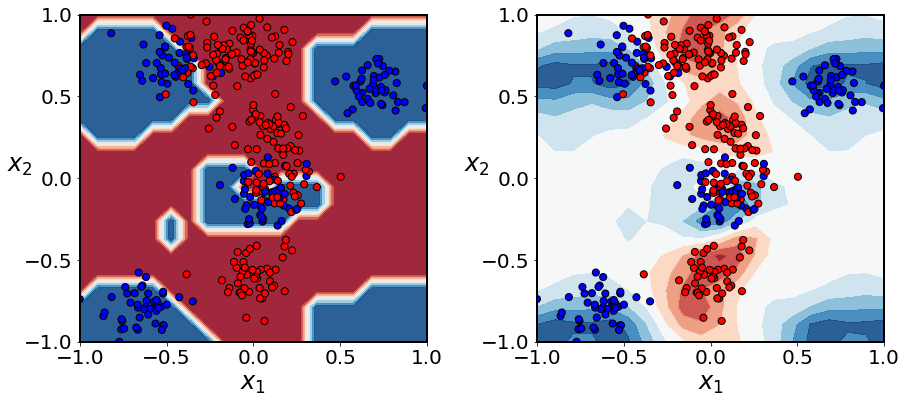

QKSVC(alpha=4.0,
      backend=<qiskit.utils.quantum_instance.QuantumInstance object at 0x7fa33c1edc00>,
      feature_map=['rx', 'cy'], n_layers=3, n_qubits=6, random_state=12345)

In [318]:
params = {'n_qubits': 6, 'n_layers': 3, 'feature_map': ['rx', 'cy'], 'alpha': 4.0, 'C': 1.0}
model(params, seed=seed, plot=True)

In [321]:
np.random.seed(seed)

train_size = 20
test_size = 20
n_splits = 5

scores_tr = []
scores_te = []

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        params = {'n_qubits': 6, 'n_layers': 3, 'feature_map': ['rx', 'cy'], 'alpha': 4.0, 'C': 1.0} 
        qsvc = QKSVC(
            n_qubits=params['n_qubits'],
            n_layers=params['n_layers'],
            feature_map=params['feature_map'], entanglement='linear',
            alpha=params['alpha'], C=params['C'], 
            random_state=_seed
        )
        qsvc.fit(X[train], y[train])

        train_scores = get_scores(qsvc, X[train], y[train])
        test_scores = get_scores(qsvc, X[test], y[test])
        scores_tr.append(train_scores)
        scores_te.append(test_scores)
        
        train_scores = get_scores(qsvc, X[train], y[train])
        test_scores = get_scores(qsvc, X[test], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.9545454545454546

Train set:
   Balanced accuracy:  0.96 +- 0.05
                  F1:  0.96 +- 0.04
             ROC_AUC:  0.99 +- 0.02
                 MCC:  0.92 +- 0.08

Test set:
   Balanced accuracy:  0.82 +- 0.07
                  F1:  0.82 +- 0.07
             ROC_AUC:  0.90 +- 0.07
                 MCC:  0.67 +- 0.14


In [326]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0

test_size = 20
n_splits = 5

for train_size in [10, 20, 40, 60, 80, 100]:

    scores_tr = []
    scores_te = []
    for _seed in np.random.randint(2**16-1, size=5):
        # print('rnd seed', _seed)

        cv = StratifiedShuffleSplit(
            n_splits=n_splits, 
            train_size=train_size, test_size=test_size, 
            random_state=_seed
        )

        i = 0
        for train, test in cv.split(X, y):
            i += 1
            # print(f"Train/Test CV Subset {i}")
            
            params = {'n_qubits': 6, 'n_layers': 3, 'feature_map': ['rx', 'cy'], 'alpha': 4.0, 'C': 1.0} 
            qsvc = QKSVC(
                n_qubits=params['n_qubits'],
                n_layers=params['n_layers'],
                feature_map=params['feature_map'], entanglement='linear',
                alpha=params['alpha'], C=params['C'], 
                random_state=_seed
            )
            qsvc.fit(X[train], y[train])

            train_scores = get_scores(qsvc, X[train], y[train])
            test_scores = get_scores(qsvc, X[test], y[test])
            scores_tr.append(train_scores)
            scores_te.append(test_scores)

    scores_tr = np.array(scores_tr)
    scores_te = np.array(scores_te)
    print(f"{train_size:>.1f}  \
{np.mean(scores_tr[:,0]):>.2f} {np.std(scores_tr[:,0]):>.2f}  \
{np.mean(scores_tr[:,3]):>.2f} {np.std(scores_tr[:,3]):>.2f}  \
{np.mean(scores_te[:,0]):>.2f} {np.std(scores_te[:,0]):>.2f}  \
{np.mean(scores_te[:,3]):>.2f} {np.std(scores_te[:,3]):>.2f}")
        

10.0  0.99 0.03  0.98 0.05  0.73 0.13  0.50 0.27
20.0  0.97 0.04  0.94 0.08  0.80 0.09  0.63 0.17
40.0  0.93 0.03  0.88 0.05  0.84 0.10  0.69 0.20
60.0  0.93 0.03  0.86 0.06  0.86 0.07  0.73 0.14
80.0  0.92 0.02  0.84 0.04  0.85 0.07  0.71 0.15
100.0  0.91 0.03  0.83 0.05  0.85 0.08  0.72 0.15


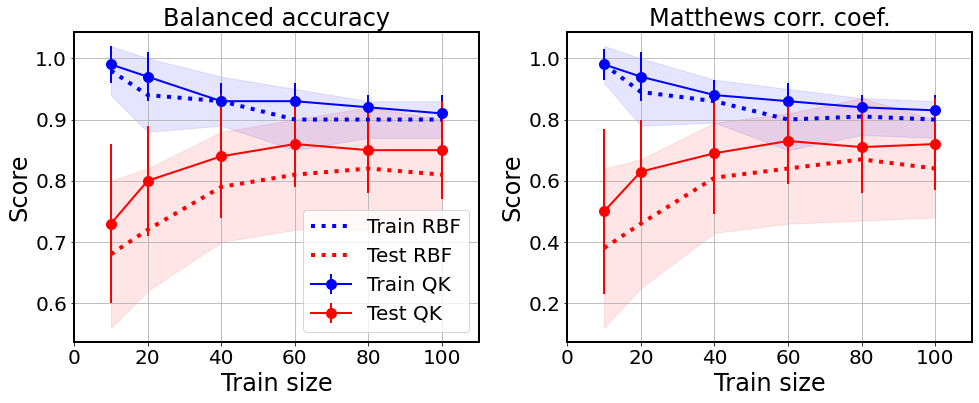

In [327]:
import pandas as pd
from io import StringIO

TESTDATA = StringIO("""
size acc_tr_mean acc_tr_std  mcc_tr_mean mcc_tr_std  acc_te_mean acc_te_std  mcc_te_mean mcc_te_std
10.0  0.99 0.03  0.98 0.05  0.73 0.13  0.50 0.27
20.0  0.97 0.04  0.94 0.08  0.80 0.09  0.63 0.17
40.0  0.93 0.03  0.88 0.05  0.84 0.10  0.69 0.20
60.0  0.93 0.03  0.86 0.06  0.86 0.07  0.73 0.14
80.0  0.92 0.02  0.84 0.04  0.85 0.07  0.71 0.15
100.0  0.91 0.03  0.83 0.05  0.85 0.08  0.72 0.15
""")

df = pd.read_table(TESTDATA, sep="\s+")

# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# acc
df.plot(ax=ax[0], x='size', y='acc_tr_mean', yerr='acc_tr_std', c='blue', lw=2, ls='-', marker='o', markersize=10, label='Train QK')
df.plot(ax=ax[0], x='size', y='acc_te_mean', yerr='acc_te_std', c='red', lw=2, ls='-', marker='o', markersize=10, label='Test QK')

df_rbf.plot(ax=ax[0], x='size', y='acc_tr_mean', yerr=None, c='blue', lw=4, ls=':', marker=None, markersize=10, label='Train RBF', legend=False)
ax[0].fill_between(df_rbf['size'], df_rbf['acc_tr_mean']-df_rbf['acc_tr_std'], df_rbf['acc_tr_mean']+df_rbf['acc_tr_std'], alpha=0.1, color='blue')

df_rbf.plot(ax=ax[0], x='size', y='acc_te_mean', yerr=None, c='red', lw=4, ls=':', marker=None, markersize=10, label='Test RBF', legend=False)
ax[0].fill_between(df_rbf['size'], df_rbf['acc_te_mean']-df_rbf['acc_te_std'], df_rbf['acc_te_mean']+df_rbf['acc_te_std'], alpha=0.1, color='red')

# mcc
df.plot(ax=ax[1], x='size', y='mcc_tr_mean', yerr='mcc_tr_std', c='blue', lw=2, ls='-', marker='o', markersize=10, label='Train QK', legend=False)
df.plot(ax=ax[1], x='size', y='mcc_te_mean', yerr='mcc_te_std', c='red', lw=2, ls='-', marker='o', markersize=10, label='Test QK', legend=False)

df_rbf.plot(ax=ax[1], x='size', y='mcc_tr_mean', yerr=None, c='blue', lw=4, ls=':', marker=None, markersize=10, label='Train RBF', legend=False)
ax[1].fill_between(df_rbf['size'], df_rbf['mcc_tr_mean']-df_rbf['mcc_tr_std'], df_rbf['mcc_tr_mean']+df_rbf['mcc_tr_std'], alpha=0.1, color='blue')

df_rbf.plot(ax=ax[1], x='size', y='mcc_te_mean', yerr=None, c='red', lw=4, ls=':', marker=None, markersize=10, label='Test RBF', legend=False)
ax[1].fill_between(df_rbf['size'], df_rbf['mcc_te_mean']-df_rbf['mcc_te_std'], df_rbf['mcc_te_mean']+df_rbf['mcc_te_std'], alpha=0.1, color='red')

ax[0].set_title('Balanced accuracy')
ax[1].set_title('Matthews corr. coef.')
for i in range(len(ax)):
    ax[i].set_xlabel('Train size', fontsize=24)
    ax[i].set_ylabel('Score', fontsize=24)
    ax[i].set_xlim(0, 110)
    ax[i].grid()
ax[0].legend(loc='lower right')
plt.tight_layout()
plt.show()

In [314]:
np.random.seed(seed)

train_size = 20
test_size = 20
n_splits = 5

scores_tr = []
scores_te = []

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        params = {'n_qubits': 5, 'n_layers': 3, 'feature_map': ['rx', 'cy'], 'alpha': 4.0, 'C': 1.0} 
        qsvc = QKSVC(
            n_qubits=params['n_qubits'],
            n_layers=params['n_layers'],
            feature_map=params['feature_map'], entanglement='linear',
            alpha=params['alpha'], C=params['C'], 
            random_state=_seed
        )
        qsvc.fit(X[train], y[train])

        train_scores = get_scores(qsvc, X[train], y[train])
        test_scores = get_scores(qsvc, X[test], y[test])
        scores_tr.append(train_scores)
        scores_te.append(test_scores)
        
        train_scores = get_scores(qsvc, X[train], y[train])
        test_scores = get_scores(qsvc, X[test], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.9545454545454546

Train set:
   Balanced accuracy:  0.97 +- 0.04
                  F1:  0.97 +- 0.04
             ROC_AUC:  0.99 +- 0.03
                 MCC:  0.94 +- 0.08

Test set:
   Balanced accuracy:  0.81 +- 0.08
                  F1:  0.82 +- 0.08
             ROC_AUC:  0.90 +- 0.08
                 MCC:  0.65 +- 0.15


# Testing circuit parameters

In [206]:
np.random.seed(seed)

train_size = 20
test_size = 20
n_splits = 5

for a in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
    scores_tr = []
    scores_te = []
    
    for _seed in np.random.randint(2**16-1, size=5):
        # print('rnd seed', _seed)

        cv = StratifiedShuffleSplit(
            n_splits=n_splits, 
            train_size=train_size, test_size=test_size, 
            random_state=_seed
        )

        i = 0
        for train, test in cv.split(X, y):
            i += 1
            # print(f"Train/Test CV Subset {i}")

            params = {'n_qubits': 6, 'n_layers': 1, 'feature_map': ['rx', ], 'alpha': a, 'C': 1.0} 
            qsvc = QKSVC(
                n_qubits=params['n_qubits'],
                n_layers=params['n_layers'],
                feature_map=params['feature_map'], entanglement='linear',
                alpha=params['alpha'], C=params['C'], 
                random_state=_seed
            )
            qsvc.fit(X[train], y[train])

            train_scores = get_scores(qsvc, X[train], y[train])
            test_scores = get_scores(qsvc, X[test], y[test])
            scores_tr.append(train_scores)
            scores_te.append(test_scores)

    scores_tr = np.array(scores_tr)
    scores_te = np.array(scores_te)
    print(f"{a:>.1f}  {np.mean(scores_tr[:,0]):>.2f} {np.std(scores_tr[:,0]):>.2f}  {np.mean(scores_te[:,0]):>.2f} {np.std(scores_te[:,0]):>.2f}")

0.5  0.60 0.10  0.56 0.10
1.0  0.73 0.12  0.67 0.10
1.5  0.79 0.07  0.69 0.10
2.0  0.87 0.07  0.81 0.09
2.5  0.85 0.09  0.82 0.07
3.0  0.90 0.05  0.81 0.08
3.5  0.90 0.06  0.79 0.10
4.0  0.93 0.06  0.85 0.09
4.5  0.91 0.05  0.83 0.08
5.0  0.93 0.06  0.79 0.07


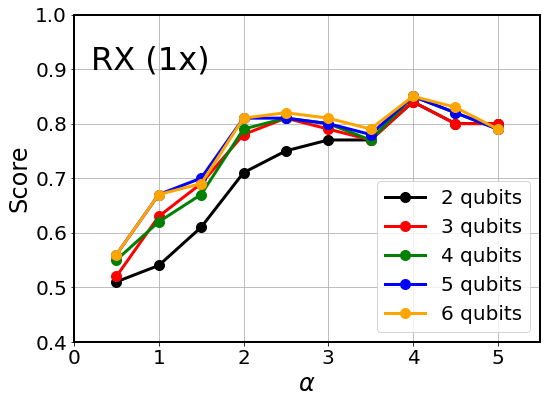

In [207]:
import pandas as pd
from io import StringIO

# RX (1x), 2 qubits
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.52 0.06  0.51 0.02
1.0  0.61 0.10  0.54 0.07
1.5  0.68 0.09  0.61 0.12
2.0  0.74 0.09  0.71 0.13
2.5  0.79 0.10  0.75 0.08
3.0  0.86 0.06  0.77 0.08
3.5  0.85 0.07  0.77 0.11
4.0  0.88 0.07  0.84 0.08
4.5  0.87 0.08  0.80 0.08
5.0  0.89 0.08  0.80 0.06
""")
df0 = pd.read_table(TESTDATA, sep="\s+")

# RX (1x), 3 qubits
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.54 0.08  0.52 0.05
1.0  0.68 0.09  0.63 0.08
1.5  0.76 0.07  0.69 0.12
2.0  0.81 0.07  0.78 0.13
2.5  0.83 0.09  0.81 0.08
3.0  0.88 0.05  0.79 0.07
3.5  0.87 0.06  0.77 0.10
4.0  0.89 0.07  0.84 0.08
4.5  0.87 0.07  0.80 0.07
5.0  0.90 0.07  0.80 0.06
""")
df1 = pd.read_table(TESTDATA, sep="\s+")

# RX (1x), 4 qubits
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.57 0.09  0.55 0.08
1.0  0.67 0.10  0.62 0.08
1.5  0.75 0.07  0.67 0.12
2.0  0.82 0.08  0.79 0.11
2.5  0.82 0.09  0.81 0.08
3.0  0.89 0.05  0.80 0.08
3.5  0.89 0.06  0.77 0.11
4.0  0.91 0.07  0.85 0.09
4.5  0.90 0.05  0.82 0.09
5.0  0.91 0.07  0.79 0.07
""")
df2 = pd.read_table(TESTDATA, sep="\s+")

# RX (1x), 5 qubits
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.58 0.10  0.56 0.09
1.0  0.73 0.11  0.67 0.09
1.5  0.78 0.07  0.70 0.11
2.0  0.85 0.08  0.81 0.10
2.5  0.84 0.09  0.81 0.07
3.0  0.90 0.05  0.80 0.08
3.5  0.89 0.06  0.78 0.09
4.0  0.92 0.07  0.85 0.08
4.5  0.90 0.05  0.82 0.08
5.0  0.92 0.07  0.79 0.07
""")
df3 = pd.read_table(TESTDATA, sep="\s+")

# # RX (1x), 6 qubits
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.60 0.10  0.56 0.10
1.0  0.73 0.12  0.67 0.10
1.5  0.79 0.07  0.69 0.10
2.0  0.87 0.07  0.81 0.09
2.5  0.85 0.09  0.82 0.07
3.0  0.90 0.05  0.81 0.08
3.5  0.90 0.06  0.79 0.10
4.0  0.93 0.06  0.85 0.09
4.5  0.91 0.05  0.83 0.08
5.0  0.93 0.06  0.79 0.07
""")
df4 = pd.read_table(TESTDATA, sep="\s+")

# # RX-CRY, 1 layer
# TESTDATA = StringIO("""
# alpha mean_tr std_tr   mean_te std_te

# """)
# df5 = pd.read_table(TESTDATA, sep="\s+")

#############################################
# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 1, figsize=(8,6))

def plot_df(df, ax, c=None, label=None):
    # df.plot(ax=ax, x='alpha', y='mean_tr', yerr=None, lw=3, ls=':', marker='o', markersize=10, label='Train', legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_tr']-df['std_tr'], df['mean_tr']+df['std_tr'], alpha=0.1, color=c)
    df.plot(ax=ax, x='alpha', y='mean_te', yerr=None, lw=3, ls='-', marker='o', markersize=10, label=label, legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_te']-df['std_te'], df['mean_te']+df['std_te'], alpha=0.1, color=c)

plot_df(df0, ax, label='2 qubits', c='black')
plot_df(df1, ax, label='3 qubits', c='red')
plot_df(df2, ax, label='4 qubits', c='green')
plot_df(df3, ax, label='5 qubits', c='blue')
plot_df(df4, ax, label='6 qubits', c='orange')
# plot_df(df5, ax, label='RX-CRY (1x)', c='cyan')

ax.text(0.2, 0.9, r'RX (1x)', fontsize=32)
ax.set_xlabel(r'$\alpha$', fontsize=24)
ax.set_ylabel('Score', fontsize=24)
ax.set_xlim(0, 5.5)
ax.set_ylim(0.4, 1.0)
ax.grid()

ax.legend(loc='lower right')

# Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

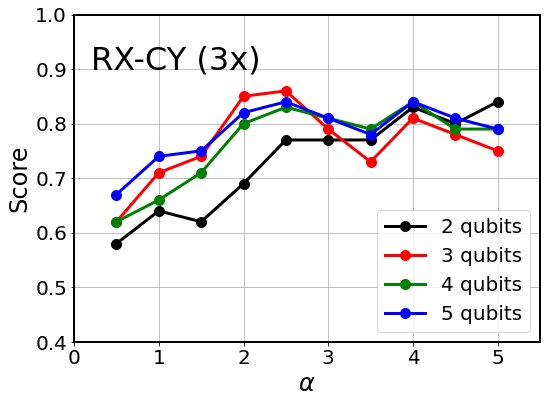

In [200]:
import pandas as pd
from io import StringIO

# RX-CY (3x), 2 qubits
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.63 0.10  0.58 0.10
1.0  0.71 0.11  0.64 0.05
1.5  0.71 0.09  0.62 0.10
2.0  0.78 0.08  0.69 0.09
2.5  0.83 0.07  0.77 0.11
3.0  0.87 0.07  0.77 0.11
3.5  0.86 0.07  0.77 0.11
4.0  0.87 0.07  0.83 0.09
4.5  0.84 0.08  0.80 0.06
5.0  0.88 0.08  0.84 0.07
""")
df0 = pd.read_table(TESTDATA, sep="\s+")

# RX-CY (3x), 3 qubits
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.69 0.10  0.62 0.09
1.0  0.80 0.10  0.71 0.11
1.5  0.86 0.05  0.74 0.09
2.0  0.91 0.06  0.85 0.08
2.5  0.90 0.06  0.86 0.05
3.0  0.91 0.07  0.79 0.10
3.5  0.89 0.06  0.73 0.10
4.0  0.91 0.06  0.81 0.10
4.5  0.90 0.06  0.78 0.10
5.0  0.90 0.07  0.75 0.12
""")
df1 = pd.read_table(TESTDATA, sep="\s+")

# RX-CY (3x), 4 qubits
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.70 0.10  0.62 0.08
1.0  0.76 0.09  0.66 0.07
1.5  0.82 0.07  0.71 0.09
2.0  0.90 0.06  0.80 0.10
2.5  0.89 0.07  0.83 0.09
3.0  0.93 0.04  0.81 0.10
3.5  0.93 0.06  0.79 0.10
4.0  0.94 0.05  0.84 0.09
4.5  0.93 0.04  0.79 0.07
5.0  0.94 0.06  0.79 0.06
""")
df2 = pd.read_table(TESTDATA, sep="\s+")

# RX-CY (3x), 5 qubits
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.73 0.09  0.67 0.10
1.0  0.83 0.08  0.74 0.10
1.5  0.87 0.05  0.75 0.08
2.0  0.92 0.06  0.82 0.09
2.5  0.91 0.06  0.84 0.08
3.0  0.93 0.05  0.81 0.11
3.5  0.94 0.05  0.78 0.10
4.0  0.94 0.05  0.84 0.07
4.5  0.93 0.04  0.81 0.07
5.0  0.95 0.05  0.79 0.08
""")
df3 = pd.read_table(TESTDATA, sep="\s+")

# # RX-ISWAP, 3 layers
# TESTDATA = StringIO("""
# alpha mean_tr std_tr   mean_te std_te

# """)
# df4 = pd.read_table(TESTDATA, sep="\s+")

# # RX-CRY, 1 layer
# TESTDATA = StringIO("""
# alpha mean_tr std_tr   mean_te std_te

# """)
# df5 = pd.read_table(TESTDATA, sep="\s+")

#############################################
# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 1, figsize=(8,6))

def plot_df(df, ax, c=None, label=None):
    # df.plot(ax=ax, x='alpha', y='mean_tr', yerr=None, lw=3, ls=':', marker='o', markersize=10, label='Train', legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_tr']-df['std_tr'], df['mean_tr']+df['std_tr'], alpha=0.1, color=c)
    df.plot(ax=ax, x='alpha', y='mean_te', yerr=None, lw=3, ls='-', marker='o', markersize=10, label=label, legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_te']-df['std_te'], df['mean_te']+df['std_te'], alpha=0.1, color=c)

plot_df(df0, ax, label='2 qubits', c='black')
plot_df(df1, ax, label='3 qubits', c='red')
plot_df(df2, ax, label='4 qubits', c='green')
plot_df(df3, ax, label='5 qubits', c='blue')
# plot_df(df4, ax, label='RX-ISWAP (3x)', c='orange')
# plot_df(df5, ax, label='RX-CRY (1x)', c='cyan')

ax.text(0.2, 0.9, r'RX-CY (3x)', fontsize=32)
ax.set_xlabel(r'$\alpha$', fontsize=24)
ax.set_ylabel('Score', fontsize=24)
ax.set_xlim(0, 5.5)
ax.set_ylim(0.4, 1.0)
ax.grid()

ax.legend(loc='lower right')

# Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

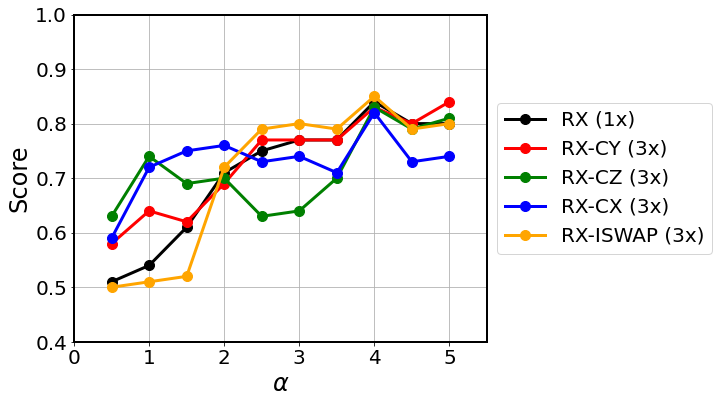

In [183]:
import pandas as pd
from io import StringIO

# RX, 1 layer
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.52 0.06  0.51 0.02
1.0  0.61 0.10  0.54 0.07
1.5  0.68 0.09  0.61 0.12
2.0  0.74 0.09  0.71 0.13
2.5  0.79 0.10  0.75 0.08
3.0  0.86 0.06  0.77 0.08
3.5  0.85 0.07  0.77 0.11
4.0  0.88 0.07  0.84 0.08
4.5  0.87 0.08  0.80 0.08
5.0  0.89 0.08  0.80 0.06
""")
df0 = pd.read_table(TESTDATA, sep="\s+")

# RX-CY encoding, 3 layers
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.63 0.10  0.58 0.10
1.0  0.71 0.11  0.64 0.05
1.5  0.71 0.09  0.62 0.10
2.0  0.78 0.08  0.69 0.09
2.5  0.83 0.07  0.77 0.11
3.0  0.87 0.07  0.77 0.11
3.5  0.86 0.07  0.77 0.11
4.0  0.87 0.07  0.83 0.09
4.5  0.84 0.08  0.80 0.06
5.0  0.88 0.08  0.84 0.07
""")
df1 = pd.read_table(TESTDATA, sep="\s+")

# RX-CZ encoding, 3 layers
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.71 0.10  0.63 0.10
1.0  0.81 0.08  0.74 0.09
1.5  0.80 0.08  0.69 0.12
2.0  0.80 0.10  0.70 0.09
2.5  0.74 0.08  0.63 0.13
3.0  0.76 0.10  0.64 0.09
3.5  0.82 0.08  0.70 0.12
4.0  0.86 0.09  0.83 0.08
4.5  0.86 0.07  0.79 0.08
5.0  0.88 0.08  0.81 0.09
""")
df2 = pd.read_table(TESTDATA, sep="\s+")

# RX-CX, 3 layers
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.65 0.11  0.59 0.09
1.0  0.80 0.09  0.72 0.10
1.5  0.87 0.05  0.75 0.09
2.0  0.86 0.06  0.76 0.10
2.5  0.84 0.08  0.73 0.08
3.0  0.88 0.06  0.74 0.11
3.5  0.86 0.06  0.71 0.11
4.0  0.86 0.08  0.82 0.08
4.5  0.85 0.07  0.73 0.08
5.0  0.88 0.07  0.74 0.12
""")
df3 = pd.read_table(TESTDATA, sep="\s+")

# RX-ISWAP, 3 layers
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.51 0.03  0.50 0.00
1.0  0.54 0.09  0.51 0.04
1.5  0.57 0.09  0.52 0.05
2.0  0.78 0.07  0.72 0.09
2.5  0.82 0.09  0.79 0.08
3.0  0.89 0.06  0.80 0.09
3.5  0.83 0.06  0.79 0.11
4.0  0.86 0.07  0.85 0.09
4.5  0.82 0.07  0.79 0.08
5.0  0.85 0.08  0.80 0.08
""")
df4 = pd.read_table(TESTDATA, sep="\s+")

# RX-CRY, 1 layer
TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.52 0.06  0.51 0.02
1.0  0.60 0.10  0.55 0.07
1.5  0.70 0.10  0.63 0.12
2.0  0.78 0.08  0.75 0.12
2.5  0.81 0.10  0.79 0.09
3.0  0.88 0.06  0.78 0.08
3.5  0.86 0.06  0.78 0.11
4.0  0.88 0.07  0.83 0.08
4.5  0.87 0.07  0.80 0.07
5.0  0.88 0.07  0.81 0.06
""")
df5 = pd.read_table(TESTDATA, sep="\s+")

#############################################
# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 1, figsize=(9,6))

def plot_df(df, ax, c=None, label=None):
    # df.plot(ax=ax, x='alpha', y='mean_tr', yerr=None, lw=3, ls=':', marker='o', markersize=10, label='Train', legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_tr']-df['std_tr'], df['mean_tr']+df['std_tr'], alpha=0.1, color=c)
    df.plot(ax=ax, x='alpha', y='mean_te', yerr=None, lw=3, ls='-', marker='o', markersize=10, label=label, legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_te']-df['std_te'], df['mean_te']+df['std_te'], alpha=0.1, color=c)

plot_df(df0, ax, label='RX (1x)', c='black')
plot_df(df1, ax, label='RX-CY (3x)', c='red')
plot_df(df2, ax, label='RX-CZ (3x)', c='green')
plot_df(df3, ax, label='RX-CX (3x)', c='blue')
plot_df(df4, ax, label='RX-ISWAP (3x)', c='orange')
# plot_df(df5, ax, label='RX-CRY (1x)', c='cyan')

# ax.text(0.25, 0.9, r'RX-CY', fontsize=32)
ax.set_xlabel(r'$\alpha$', fontsize=24)
ax.set_ylabel('Score', fontsize=24)
ax.set_xlim(0, 5.5)
ax.set_ylim(0.4, 1.0)
ax.grid()

# ax.legend(loc='lower right', bbox_to_anchor=(1.1, -0.1))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

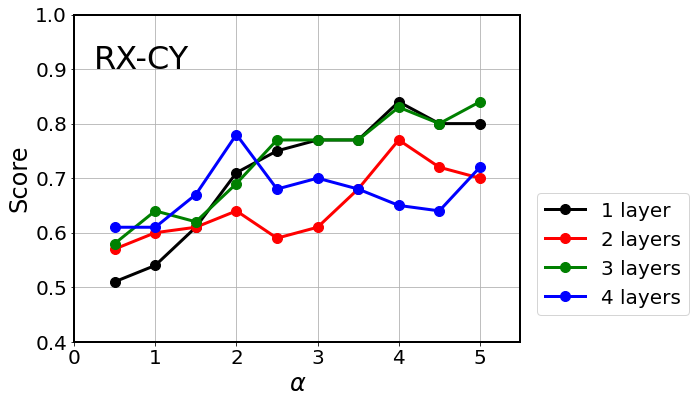

In [186]:
import pandas as pd
from io import StringIO

# RX-CY encoding

TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.52 0.06  0.51 0.02
1.0  0.61 0.10  0.54 0.07
1.5  0.68 0.09  0.61 0.12
2.0  0.74 0.09  0.71 0.13
2.5  0.79 0.10  0.75 0.08
3.0  0.86 0.06  0.77 0.08
3.5  0.85 0.07  0.77 0.11
4.0  0.88 0.07  0.84 0.08
4.5  0.87 0.08  0.80 0.08
5.0  0.89 0.08  0.80 0.06
""")
df1 = pd.read_table(TESTDATA, sep="\s+")

TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.60 0.10  0.57 0.09
1.0  0.67 0.10  0.60 0.06
1.5  0.67 0.07  0.61 0.07
2.0  0.67 0.06  0.64 0.10
2.5  0.63 0.10  0.59 0.08
3.0  0.73 0.09  0.61 0.10
3.5  0.80 0.06  0.68 0.11
4.0  0.83 0.07  0.77 0.12
4.5  0.80 0.07  0.72 0.06
5.0  0.79 0.10  0.70 0.11
""")
df2 = pd.read_table(TESTDATA, sep="\s+")

TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.63 0.10  0.58 0.10
1.0  0.71 0.11  0.64 0.05
1.5  0.71 0.09  0.62 0.10
2.0  0.78 0.08  0.69 0.09
2.5  0.83 0.07  0.77 0.11
3.0  0.87 0.07  0.77 0.11
3.5  0.86 0.07  0.77 0.11
4.0  0.87 0.07  0.83 0.09
4.5  0.84 0.08  0.80 0.06
5.0  0.88 0.08  0.84 0.07
""")
df3 = pd.read_table(TESTDATA, sep="\s+")

TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.70 0.09  0.61 0.08
1.0  0.68 0.09  0.61 0.06
1.5  0.76 0.08  0.67 0.11
2.0  0.85 0.05  0.78 0.11
2.5  0.77 0.07  0.68 0.11
3.0  0.81 0.07  0.70 0.10
3.5  0.79 0.12  0.68 0.11
4.0  0.74 0.08  0.65 0.12
4.5  0.74 0.10  0.64 0.12
5.0  0.78 0.08  0.72 0.10
""")
df4 = pd.read_table(TESTDATA, sep="\s+")

#############################################
# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 1, figsize=(11,6))

def plot_df(df, ax, c=None, label=None):
    # df.plot(ax=ax, x='alpha', y='mean_tr', yerr=None, lw=3, ls=':', marker='o', markersize=10, label='Train', legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_tr']-df['std_tr'], df['mean_tr']+df['std_tr'], alpha=0.1, color=c)
    df.plot(ax=ax, x='alpha', y='mean_te', yerr=None, lw=3, ls='-', marker='o', markersize=10, label=label, legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_te']-df['std_te'], df['mean_te']+df['std_te'], alpha=0.1, color=c)

plot_df(df1, ax, label='1 layer', c='black')
plot_df(df2, ax, label='2 layers', c='red')
plot_df(df3, ax, label='3 layers', c='green')
plot_df(df4, ax, label='4 layers', c='blue')

ax.text(0.25, 0.9, r'RX-CY', fontsize=32)
ax.set_xlabel(r'$\alpha$', fontsize=24)
ax.set_ylabel('Score', fontsize=24)
ax.set_xlim(0, 5.5)
ax.set_ylim(0.4, 1.0)
ax.grid()
ax.legend(loc='lower right', bbox_to_anchor=(1.4, 0.05))
plt.tight_layout()
plt.show()

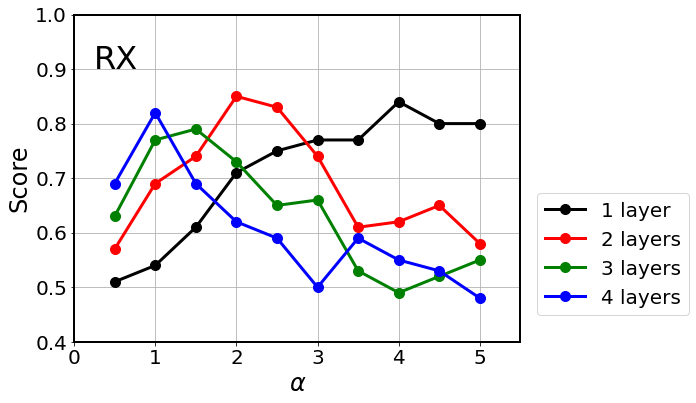

In [195]:
import pandas as pd
from io import StringIO

# RX encoding - 5 splits/5 seeds

TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.52 0.06  0.51 0.02
1.0  0.61 0.10  0.54 0.07
1.5  0.68 0.09  0.61 0.12
2.0  0.74 0.09  0.71 0.13
2.5  0.79 0.10  0.75 0.08
3.0  0.86 0.06  0.77 0.08
3.5  0.85 0.07  0.77 0.11
4.0  0.88 0.07  0.84 0.08
4.5  0.87 0.08  0.80 0.08
5.0  0.89 0.08  0.80 0.06
""")
df1 = pd.read_table(TESTDATA, sep="\s+")

TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.61 0.10  0.57 0.09
1.0  0.77 0.10  0.69 0.10
1.5  0.84 0.07  0.74 0.10
2.0  0.89 0.07  0.85 0.08
2.5  0.85 0.08  0.83 0.08
3.0  0.85 0.07  0.74 0.10
3.5  0.79 0.08  0.61 0.11
4.0  0.80 0.07  0.62 0.12
4.5  0.80 0.08  0.65 0.15
5.0  0.78 0.09  0.58 0.11
""")
df2 = pd.read_table(TESTDATA, sep="\s+")

TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.72 0.10  0.63 0.10
1.0  0.85 0.08  0.77 0.09
1.5  0.88 0.06  0.79 0.08
2.0  0.83 0.07  0.73 0.11
2.5  0.77 0.09  0.65 0.11
3.0  0.79 0.11  0.66 0.15
3.5  0.75 0.08  0.53 0.12
4.0  0.73 0.09  0.49 0.11
4.5  0.73 0.09  0.52 0.14
5.0  0.78 0.09  0.55 0.11
""")
df3 = pd.read_table(TESTDATA, sep="\s+")

TESTDATA = StringIO("""
alpha mean_tr std_tr   mean_te std_te
0.5  0.77 0.08  0.69 0.11
1.0  0.88 0.06  0.82 0.08
1.5  0.81 0.08  0.69 0.11
2.0  0.79 0.08  0.62 0.11
2.5  0.77 0.09  0.59 0.10
3.0  0.76 0.08  0.50 0.09
3.5  0.74 0.07  0.59 0.11
4.0  0.70 0.10  0.55 0.09
4.5  0.69 0.09  0.53 0.11
5.0  0.73 0.09  0.48 0.12
""")
df4 = pd.read_table(TESTDATA, sep="\s+")

#############################################
# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 1, figsize=(11,6))

def plot_df(df, ax, c=None, label=None):
    # df.plot(ax=ax, x='alpha', y='mean_tr', yerr=None, lw=3, ls=':', marker='o', markersize=10, label='Train', legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_tr']-df['std_tr'], df['mean_tr']+df['std_tr'], alpha=0.1, color=c)
    df.plot(ax=ax, x='alpha', y='mean_te', yerr=None, lw=3, ls='-', marker='o', markersize=10, label=label, legend=False, c=c)
    # ax.fill_between(df['alpha'], df['mean_te']-df['std_te'], df['mean_te']+df['std_te'], alpha=0.1, color=c)

plot_df(df1, ax, label='1 layer', c='black')
plot_df(df2, ax, label='2 layers', c='red')
plot_df(df3, ax, label='3 layers', c='green')
plot_df(df4, ax, label='4 layers', c='blue')
    
ax.text(0.25, 0.9, r'RX', fontsize=32)
ax.set_xlabel(r'$\alpha$', fontsize=24)
ax.set_ylabel('Score', fontsize=24)
ax.set_xlim(0, 5.5)
ax.set_ylim(0.4, 1.0)
ax.grid()
ax.legend(loc='lower right', bbox_to_anchor=(1.4, 0.05))
plt.tight_layout()
plt.show()

In [218]:
np.random.seed(seed)

train_size = 20
test_size = 20
n_splits = 5

for a in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    scores_tr = []
    scores_te = []
    
    for _seed in np.random.randint(2**16-1, size=5):
        # print('rnd seed', _seed)

        cv = StratifiedShuffleSplit(
            n_splits=n_splits, 
            train_size=train_size, test_size=test_size, 
            random_state=_seed
        )

        i = 0
        for train, test in cv.split(X, y):
            i += 1
            # print(f"Train/Test CV Subset {i}")

            params = {'n_qubits': a, 'n_layers': 3, 'feature_map': ['rx', 'cy'], 'alpha': 2.5, 'C': 1.0} 
            qsvc = QKSVC(
                n_qubits=params['n_qubits'],
                n_layers=params['n_layers'],
                feature_map=params['feature_map'], entanglement='linear',
                alpha=params['alpha'], C=params['C'], 
                random_state=_seed
            )
            qsvc.fit(X[train], y[train])

            train_scores = get_scores(qsvc, X[train], y[train])
            test_scores = get_scores(qsvc, X[test], y[test])
            scores_tr.append(train_scores)
            scores_te.append(test_scores)

    scores_tr = np.array(scores_tr)
    scores_te = np.array(scores_te)
    print(f"{a:>.1f}  {np.mean(scores_tr[:,0]):>.2f} {np.std(scores_tr[:,0]):>.2f}  {np.mean(scores_te[:,0]):>.2f} {np.std(scores_te[:,0]):>.2f}")

2.0  0.84 0.07  0.77 0.08
3.0  0.91 0.06  0.82 0.10
4.0  0.90 0.07  0.77 0.09
5.0  0.93 0.06  0.83 0.07
6.0  0.92 0.07  0.83 0.09
7.0  0.93 0.05  0.79 0.10
8.0  0.93 0.05  0.77 0.10
9.0  0.94 0.06  0.81 0.11
10.0  0.93 0.04  0.75 0.08


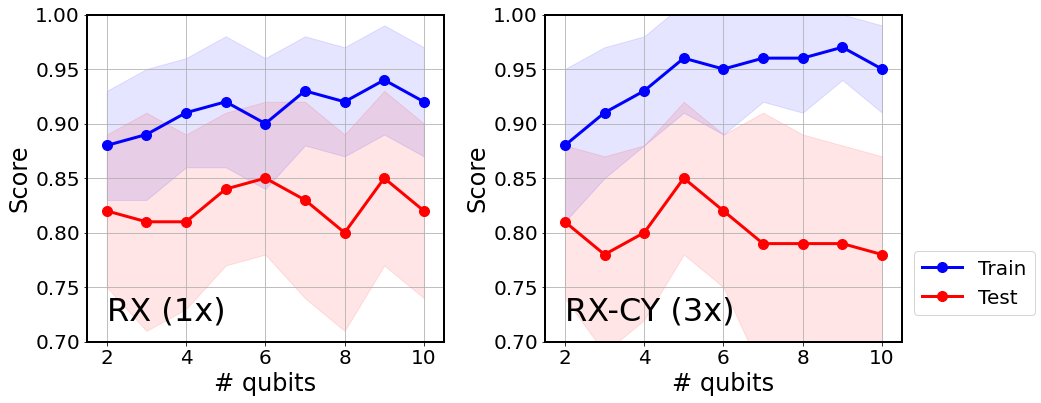

In [217]:
import pandas as pd
from io import StringIO

# RX encoding, 1 layer, a=4.0
TESTDATA = StringIO("""
qubits mean_tr std_tr   mean_te std_te
2.0  0.88 0.05  0.82 0.07
3.0  0.89 0.06  0.81 0.10
4.0  0.91 0.05  0.81 0.08
5.0  0.92 0.06  0.84 0.07
6.0  0.90 0.06  0.85 0.07
7.0  0.93 0.05  0.83 0.09
8.0  0.92 0.05  0.80 0.09
9.0  0.94 0.05  0.85 0.08
10.0  0.92 0.05  0.82 0.08
""")
df1 = pd.read_table(TESTDATA, sep="\s+")

# RX-CY (3 layers) encoding, a=4
TESTDATA = StringIO("""
qubits mean_tr std_tr   mean_te std_te
2.0  0.88 0.07  0.81 0.07
3.0  0.91 0.06  0.78 0.09
4.0  0.93 0.05  0.80 0.08
5.0  0.96 0.05  0.85 0.07
6.0  0.95 0.06  0.82 0.07
7.0  0.96 0.04  0.79 0.12
8.0  0.96 0.05  0.79 0.10
9.0  0.97 0.03  0.79 0.09
10.0  0.95 0.04  0.78 0.09
""")
df2 = pd.read_table(TESTDATA, sep="\s+")

#############################################
# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, figsize=(15,6))

def plot_df(df, ax):
    df.plot(ax=ax, x='qubits', y='mean_tr', yerr=None, lw=3, ls='-', marker='o', markersize=10, label='Train', legend=False, c='blue')
    ax.fill_between(df['qubits'], df['mean_tr']-df['std_tr'], df['mean_tr']+df['std_tr'], alpha=0.1, color='blue')
    df.plot(ax=ax, x='qubits', y='mean_te', yerr=None, lw=3, ls='-', marker='o', markersize=10, label='Test', legend=False, c='red')
    ax.fill_between(df['qubits'], df['mean_te']-df['std_te'], df['mean_te']+df['std_te'], alpha=0.1, color='red')

plot_df(df1, ax=ax[0])
plot_df(df2, ax=ax[1])
    
ax[0].text(2.0, 0.72, r'RX (1x)', fontsize=32)
ax[1].text(2.0, 0.72, r'RX-CY (3x)', fontsize=32)
for a in ax:
    a.set_xlabel('# qubits', fontsize=24)
    a.set_ylabel('Score', fontsize=24)
    a.set_xlim(1.5, 10.5)
    a.set_ylim(0.7, 1.0)
    a.grid()
ax[1].legend(loc='lower right', bbox_to_anchor=(1.4, 0.05))
plt.tight_layout()
plt.show()

# Hyperparameter search

In [348]:
def cv_scores(model, seed=None):
    """ """ 
    np.random.seed(seed)

    train_size = 20
    test_size = 20
    n_splits = 5

    scores_tr = []
    scores_tt = []
    for _seed in np.random.randint(2**16-1, size=5):

        cv = StratifiedShuffleSplit(
            n_splits=n_splits, 
            train_size=train_size, test_size=test_size, 
            random_state=_seed
        )

        i = 0
        for train, test in cv.split(X, y):
            i += 1
            model.fit(X[train,:], y[train])
            train_scores = get_scores(model, X[train,:], y[train])
            test_scores = get_scores(model, X[test,:], y[test])
            scores_tr.append(train_scores)
            scores_tt.append(test_scores)

    print('')
    print('==== Cross-Validation Scores ====')
    print("\nBest train score: ", best_score)
    print_cv_scores(scores_tr, title='Train set:')
    print_cv_scores(scores_tt, title='Test set:')

In [345]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5],
    "C": [1, 10, 100],
    "n_layers": [1, 2, 3, 4, 5],
    "n_qubits": [2, 3, 4, 5, 6, 7],
    "feature_map": [
                    ['rx'],
                    ['rx', 'cx'], 
                    ['rx', 'cy'], 
                    ['rx', 'cz'], 
                    ['rx', 'ch'], 
                    ['rx', 'swap'], 
                    ['rx', 'iswap'],
                    ['rx', 'ry'],
                    ['rx', 'ry', 'cx'],
                    ['rx', 'ry', 'cy'],
                    ['rx', 'ry', 'cz'],
                    ['rx', 'rxx'],
                    ['rx', 'ryy'],
                    ['rx', 'rzz'],
                    ['rx', 'crx'],
                    ['rx', 'cry'],
                    ['rx', 'crz'],
                   ],
}

train_size = 40
test_size = 20
_X_train, _X_test, _y_train, _y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=101,
)

gs = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=4,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
gs.fit(_X_train, _y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

train_scores = get_scores(gs.best_estimator_, _X_train, _y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(gs.best_estimator_, _X_test,  _y_test)
print_scores(test_scores, title='Test scores:')

Best grid search parameters: {'C': 10, 'alpha': 4.5, 'feature_map': ['rx', 'iswap'], 'n_layers': 2, 'n_qubits': 3}
Best training score: 0.9545454545454546

Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.98
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.85
             ROC_AUC:  0.83
                 MCC:  0.74


In [375]:
v = gs.cv_results_['mean_test_score']
s = gs.cv_results_['std_test_score']

idxs = np.where((v > 0.95) & (s < 0.4))[0]
print(idxs)

for i in idxs:
    print(i, v[i], s[i])
    print(gs.cv_results_['params'][i])

[7837]
7837 0.9545454545454546 0.045454545454545414
{'C': 10, 'alpha': 4.5, 'feature_map': ['rx', 'iswap'], 'n_layers': 2, 'n_qubits': 3}


7837
0.9217171717171717
params {'C': 100, 'alpha': 3.0, 'feature_map': ['rx'], 'n_layers': 1, 'n_qubits': 5}

Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  1.00
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  0.96
                 MCC:  0.80


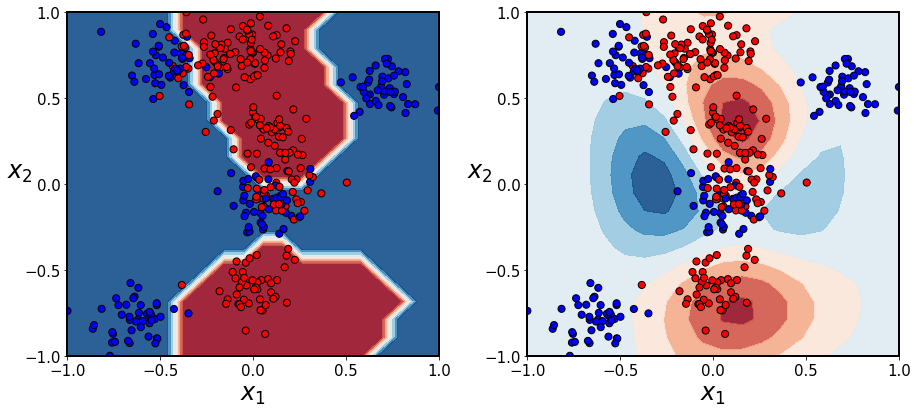


==== Cross-Validation Scores ====

Best train score:  0.9444444444444444

Train set:
   Balanced accuracy:  0.98 +- 0.04
                  F1:  0.98 +- 0.04
             ROC_AUC:  0.99 +- 0.03
                 MCC:  0.95 +- 0.07

Test set:
   Balanced accuracy:  0.79 +- 0.12
                  F1:  0.78 +- 0.12
             ROC_AUC:  0.83 +- 0.11
                 MCC:  0.58 +- 0.24


In [373]:
print(gs.best_index_)

i = 10203
print(gs.cv_results_['mean_test_score'][i])
print('params', gs.cv_results_['params'][i])

qsvc = model(gs.cv_results_['params'][i], plot=True)
cv_scores(qsvc, seed=seed)

## Model cross-validation

In [363]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

train_size = 20
test_size = 20
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        # params = {'C': 10, 'alpha': 4.5, 'feature_map': ['rx', 'iswap'], 'n_layers': 2, 'n_qubits': 3}
        # params = {'C': 100, 'alpha': 3.0, 'feature_map': ['rx', 'ryy'], 'n_layers': 1, 'n_qubits': 2}
        # params = {'C': 100, 'alpha': 1.0, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 2, 'n_qubits': 3}
        params = {'C': 1, 'alpha': 1.0, 'feature_map': ['rx', 'ry'], 'n_layers': 3, 'n_qubits': 4}

        qsvc = QKSVC(
            n_qubits=params['n_qubits'],
            n_layers=params['n_layers'],
            feature_map=params['feature_map'], entanglement='linear',
            alpha=params['alpha'], C=params['C'], 
            random_state=_seed
        ) 
        qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.9444444444444444

Train set:
   Balanced accuracy:  0.92 +- 0.06
                  F1:  0.92 +- 0.06
             ROC_AUC:  0.98 +- 0.03
                 MCC:  0.85 +- 0.11

Test set:
   Balanced accuracy:  0.84 +- 0.06
                  F1:  0.84 +- 0.07
             ROC_AUC:  0.91 +- 0.07
                 MCC:  0.70 +- 0.12


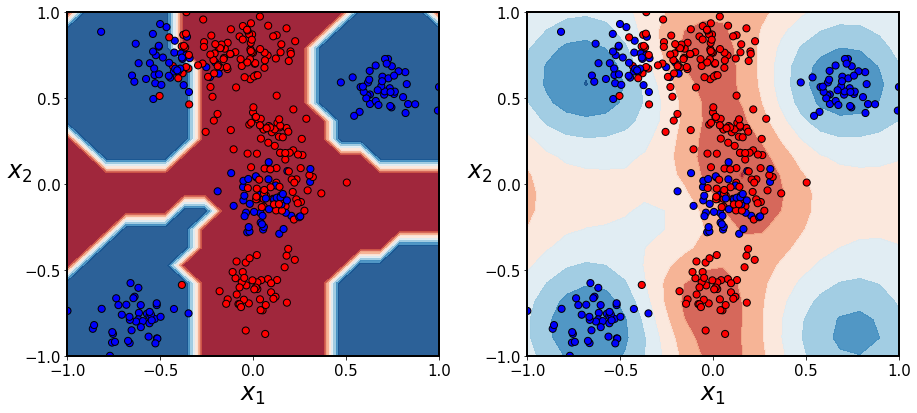

In [364]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(best_qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(best_qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

In [385]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5],
    "C": [1, 10, 100],
    "n_layers": [1, 2, 3, 4, 5],
    "n_qubits": [2, 3, 4, 5, 6, 7],
    "feature_map": [
                    ['rx'],
                    ['rx', 'cx'], 
                    ['rx', 'cy'], 
                    ['rx', 'cz'], 
                    ['rx', 'ch'], 
                    ['rx', 'swap'], 
                    ['rx', 'iswap'],
                    ['rx', 'ry'],
                    ['rx', 'ry', 'cx'],
                    ['rx', 'ry', 'cy'],
                    ['rx', 'ry', 'cz'],
                    ['rx', 'rxx'],
                    ['rx', 'ryy'],
                    ['rx', 'rzz'],
                    ['rx', 'crx'],
                    ['rx', 'cry'],
                    ['rx', 'crz'],
                   ],
}

train_size = 60
test_size = 20
_X_train, _X_test, _y_train, _y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=101,
)

gs = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=4,
    refit=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
)
gs.fit(_X_train, _y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

train_scores = get_scores(gs.best_estimator_, _X_train, _y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(gs.best_estimator_, _X_test,  _y_test)
print_scores(test_scores, title='Test scores:')

Best grid search parameters: {'C': 10, 'alpha': 2.5, 'feature_map': ['rx', 'ry', 'cy'], 'n_layers': 3, 'n_qubits': 3}
Best training score: 0.9107744107744108

Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.97
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.81
                  F1:  0.80
             ROC_AUC:  0.86
                 MCC:  0.62


In [392]:
v = gs.cv_results_['mean_test_score']
s = gs.cv_results_['std_test_score']

idxs = np.where((v > 0.89) & (s < 0.4))[0]
print(idxs)

for i in idxs:
    print(i, v[i], s[i])
    print(gs.cv_results_['params'][i])

[ 1843  3769  4732  4881  4883  4885  4887  5354  5385  5387  5891  5893
  6399  7837 11916]
1843 0.8956228956228957 0.11067663241679192
{'C': 1, 'alpha': 2.5, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 3, 'n_qubits': 3}
3769 0.8905723905723906 0.04542335879876108
{'C': 1, 'alpha': 4.5, 'feature_map': ['rx', 'iswap'], 'n_layers': 4, 'n_qubits': 3}
4732 0.8956228956228957 0.06904409647949451
{'C': 10, 'alpha': 1.5, 'feature_map': ['rx', 'ch'], 'n_layers': 4, 'n_qubits': 6}
4881 0.8956228956228957 0.06904409647949451
{'C': 10, 'alpha': 1.5, 'feature_map': ['rx', 'ry', 'cy'], 'n_layers': 4, 'n_qubits': 5}
4883 0.8956228956228957 0.06904409647949451
{'C': 10, 'alpha': 1.5, 'feature_map': ['rx', 'ry', 'cy'], 'n_layers': 4, 'n_qubits': 7}
4885 0.8922558922558922 0.04130587254675184
{'C': 10, 'alpha': 1.5, 'feature_map': ['rx', 'ry', 'cy'], 'n_layers': 5, 'n_qubits': 3}
4887 0.8922558922558922 0.04130587254675184
{'C': 10, 'alpha': 1.5, 'feature_map': ['rx', 'ry', 'cy'], 'n_layers': 5, 'n

5893
0.8956228956228957
params {'C': 10, 'alpha': 1.5, 'feature_map': ['rx', 'ch'], 'n_layers': 4, 'n_qubits': 6}

Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  1.00
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  0.97
                 MCC:  0.80


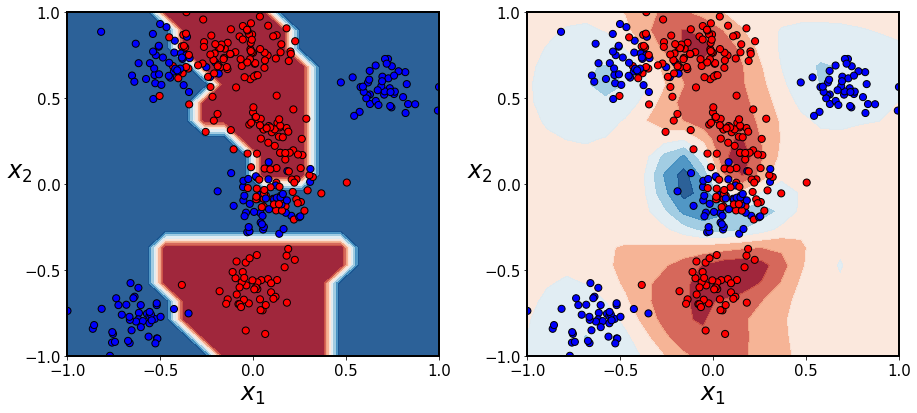


==== Cross-Validation Scores ====

Best train score:  0.9444444444444444

Train set:
   Balanced accuracy:  0.97 +- 0.03
                  F1:  0.97 +- 0.03
             ROC_AUC:  0.99 +- 0.02
                 MCC:  0.95 +- 0.06

Test set:
   Balanced accuracy:  0.80 +- 0.09
                  F1:  0.80 +- 0.09
             ROC_AUC:  0.86 +- 0.10
                 MCC:  0.62 +- 0.18


In [393]:
print(gs.best_index_)

i = 4732
print(gs.cv_results_['mean_test_score'][i])
print('params', gs.cv_results_['params'][i])

qsvc = model(gs.cv_results_['params'][i], plot=True)
cv_scores(qsvc, seed=seed)

In [406]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5],
    "C": [1, 10],
    "n_layers": [1, 2, 3, 4, 5],
    "n_qubits": [2, 3, 4, 5, 6],
    "feature_map": [
                    ['h', 'rz'], 
                    ['h', 'rz', 'cx'], 
                    ['h', 'cx', 'rz'], 
                    ['h', 'rz', 'rzz'], 
                    ['h', 'rz', 'rxx'], 
                    ['h', 'rz', 'crx'], 
                    ['h', 'rz', 'cry'], 
                    ['h', 'rz', 'crz'], 
                   ],
}

train_size = 40
test_size = 20
_X_train, _X_test, _y_train, _y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=101,
)

gs = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=4,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
gs.fit(_X_train, _y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

train_scores = get_scores(gs.best_estimator_, _X_train, _y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(gs.best_estimator_, _X_test,  _y_test)
print_scores(test_scores, title='Test scores:')

Best grid search parameters: {'C': 1, 'alpha': 3.5, 'feature_map': ['h', 'cx', 'rz'], 'n_layers': 3, 'n_qubits': 6}
Best training score: 0.9494949494949495

Train scores:
   Balanced accuracy:  0.92
                  F1:  0.92
             ROC_AUC:  0.99
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.85
             ROC_AUC:  0.92
                 MCC:  0.74


In [417]:
v = gs.cv_results_['mean_test_score']
s = gs.cv_results_['std_test_score']

idxs = np.where((v > 0.92) & (s < 0.4))[0]
print(idxs)

for i in idxs:
    print(i, v[i], s[i])
    print(gs.cv_results_['params'][i])

[ 222  223  224  413  414  609  767  783  809  874 1009 1064 1097 1146
 1202 1203 1204 1227 1228 1229 1252 1253 1254 1264 1276 1277 1278 1279
 1402 1403 1427 1428 1446 1452 1453 1476 1477 1478 1497 1614 1617 1687
 1688 1691 1692 1697 1712 1713 1748 1809 1886 1897 1916 1963 1986 2004
 2007 2010 2029 2054 2096 2102 2121 2138 2202 2211 2213 2227 2252 2276
 2356 2405 2528 2601 2626 2651 2722 2728 2754 2800 2801 2825 2826 2850
 2851 2868 2912 2922 2926 2952 3001 3007 3026 3046 3048 3051 3073 3105
 3112 3126]
222 0.9217171717171717 0.07828282828282829
{'C': 1, 'alpha': 1.5, 'feature_map': ['h', 'rz'], 'n_layers': 5, 'n_qubits': 4}
223 0.9217171717171717 0.07828282828282829
{'C': 1, 'alpha': 1.5, 'feature_map': ['h', 'rz'], 'n_layers': 5, 'n_qubits': 5}
224 0.9217171717171717 0.07828282828282829
{'C': 1, 'alpha': 1.5, 'feature_map': ['h', 'rz'], 'n_layers': 5, 'n_qubits': 6}
413 0.9217171717171717 0.07828282828282829
{'C': 1, 'alpha': 2.0, 'feature_map': ['h', 'rz'], 'n_layers': 3, 'n_qubits'

1064
0.9217171717171717
params {'C': 10, 'alpha': 2.0, 'feature_map': ['h', 'cx', 'rz'], 'n_layers': 1, 'n_qubits': 6}

Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.99
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.81
                  F1:  0.80
             ROC_AUC:  0.83
                 MCC:  0.62


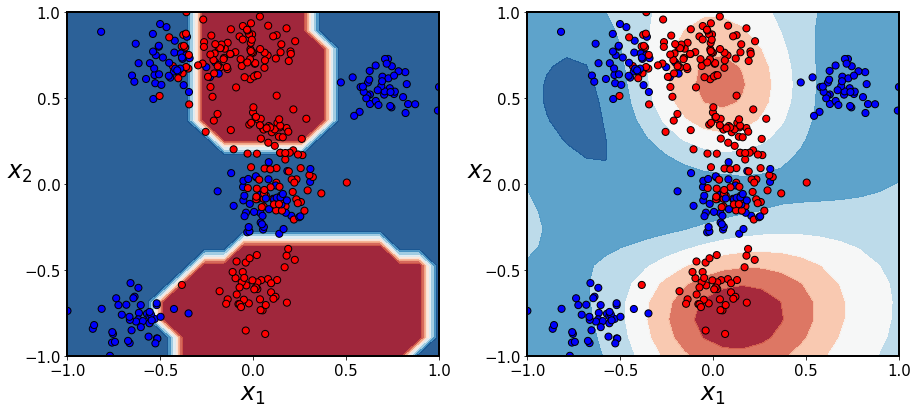


==== Cross-Validation Scores ====

Best train score:  0.9444444444444444

Train set:
   Balanced accuracy:  0.93 +- 0.06
                  F1:  0.93 +- 0.06
             ROC_AUC:  0.98 +- 0.03
                 MCC:  0.87 +- 0.11

Test set:
   Balanced accuracy:  0.79 +- 0.10
                  F1:  0.79 +- 0.10
             ROC_AUC:  0.86 +- 0.09
                 MCC:  0.60 +- 0.19


In [419]:
print(gs.best_index_)

i = 2054
print(gs.cv_results_['mean_test_score'][i])
print('params', gs.cv_results_['params'][i])

qsvc = model(gs.cv_results_['params'][i], plot=True)
cv_scores(qsvc, seed=seed)

In [330]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=6,
    num_layers=1,
    gates=['RX', ], entanglement='linear',
)

large_font = {
    "fontsize": 12,
    "subfontsize": 10,  
}
print(fm.draw(plot_barriers=False, fold=180, output='text', scale=2, style=large_font, initial_state=True))

        ┌────────────┐ 
q_0: |0>┤ Rx(x[0]*α) ├─
        ├────────────┤ 
q_1: |0>┤ Rx(x[1]*α) ├─
        ├────────────┤ 
q_2: |0>┤ Rx(x[0]*α) ├─
        ├────────────┤ 
q_3: |0>┤ Rx(x[1]*α) ├─
        ├────────────┤ 
q_4: |0>┤ Rx(x[0]*α) ├─
        ├────────────┤ 
q_5: |0>┤ Rx(x[1]*α) ├─
        └────────────┘ 


In [329]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=6,
    num_layers=3,
    gates=['RX', 'CY',], entanglement='linear',
)

large_font = {
    "fontsize": 12,
    "subfontsize": 10,  
}
print(fm.draw(plot_barriers=False, fold=180, output='text', scale=10, style=large_font, initial_state=True))

        ┌────────────┐                           ┌────────────┐                           ┌────────────┐                           
q_0: |0>┤ Rx(x[0]*α) ├───■───────────────────────┤ Rx(x[0]*α) ├───■───────────────────────┤ Rx(x[0]*α) ├───■───────────────────────
        ├────────────┤ ┌─┴─┐                     ├────────────┤ ┌─┴─┐                     ├────────────┤ ┌─┴─┐                     
q_1: |0>┤ Rx(x[1]*α) ├─┤ Y ├──■──────────────────┤ Rx(x[1]*α) ├─┤ Y ├──■──────────────────┤ Rx(x[1]*α) ├─┤ Y ├──■──────────────────
        ├────────────┤ └───┘┌─┴─┐                ├────────────┤ └───┘┌─┴─┐                ├────────────┤ └───┘┌─┴─┐                
q_2: |0>┤ Rx(x[0]*α) ├──────┤ Y ├──■─────────────┤ Rx(x[0]*α) ├──────┤ Y ├──■─────────────┤ Rx(x[0]*α) ├──────┤ Y ├──■─────────────
        ├────────────┤      └───┘┌─┴─┐           ├────────────┤      └───┘┌─┴─┐           ├────────────┤      └───┘┌─┴─┐           
q_3: |0>┤ Rx(x[1]*α) ├───────────┤ Y ├──■────────┤ Rx(x[1]*α) ├───────────┤ 